In [58]:
import wfdb
import os
import pandas as pd
import wfdb.processing as wp
import numpy as np
import pickle
from biosppy.signals import ecg, tools

import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch import nn, optim

import pytorch_model_summary

from sklearn.preprocessing import MinMaxScaler as mms

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
from matplotlib.patheffects import withStroke
from matplotlib.gridspec import GridSpec

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIbLE_DEVICES"] = "0"

In [3]:
# Data Extract From Physionet *.dat

input_path = "../physionet/mit-bih_arr/1.0.0/"
records = open(input_path+"RECORDS","r")
records_list = []
for l in records:
    l = l.rstrip()
    records_list.append(l)
records.close()
print(records_list)

NORMAL_ANN = ['N', 'L', 'R']
SUPRA_ANN = ['e',"j","A","a","J","S"]
VENTRI_ANN = ['V', 'E']
FUSION_ANN = ['F']
UNCLASS_ANN = ['/', 'f', 'Q']
ANN_DICT = {0:"N", 1:"S", 2:"V", 3:"F", 4:"Q", 5:"-"}

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


In [4]:
def extract_from_sbj(idx, sampfrom, sampto):
    record_sig = wfdb.rdsamp(input_path+records_list[idx], channels=[0], sampfrom=sampfrom, sampto = sampto)
    record_ann = list(wfdb.rdann(input_path+records_list[idx],"atr",sampfrom=sampfrom, sampto = sampto).sample)[0:] # R Peak x_position
    record_ann_sym = list(wfdb.rdann(input_path+records_list[idx], "atr",sampfrom=sampfrom, sampto = sampto).symbol)[0:] # R Peak Symbol
    interval = wp.ann2rr(input_path+records_list[idx], 'atr', as_array=True)
    
    """
    0 : N | 1 : S | 2 : V | 3 : F | 4 : Q
    """
    for i,sym in enumerate(record_ann_sym):
        if sym in NORMAL_ANN:
            record_ann_sym[i] = 0
        elif sym in SUPRA_ANN:
            record_ann_sym[i] = 1
        elif sym in VENTRI_ANN:
            record_ann_sym[i] = 2
        elif sym in FUSION_ANN:
            record_ann_sym[i] = 3
        elif sym in UNCLASS_ANN:
            record_ann_sym[i] = 4
        else:
            record_ann_sym[i] = 5

    return record_sig, record_ann, record_ann_sym

In [ ]:
seg_points = []

"""
첫 rpeak는 next_Rpeak랑만 계산
"""
l_ann = len(record_ann)
last_points = len(record_sig[0])-1

N_Sig = []
S_Sig = []
V_Sig = []
F_Sig = []
Q_Sig = []

for i in range(l_ann):
    
    now_r = record_ann[i]
    now_sym = (ANN_DICT[record_ann_sym[i]],record_ann_sym[i])
    if now_sym[0] == "-":
        continue
    if i == 0: # 첫번째 예외처리
        next_r = record_ann[i+1]
        next_points = (next_r + now_r) // 2
        prev_points = 0
    elif i == l_ann-1: #마지막 예외처리
        prev_r = record_ann[i-1]
        prev_points = (prev_r + now_r) // 2
        next_points = last_points
    else: 
        prev_r = record_ann[i-1]
        next_r = record_ann[i+1]

        prev_points = (prev_r+now_r)//2
        next_points = (next_r+now_r)//2
    
    
#     print(prev_points, next_points, "Size :", (next_points-prev_points), now_sym)
    # Beat Segmentation
    if now_sym[0] == "N":
        N_Sig.append([prev_points,next_points])
    elif now_sym[0] == "S":
        S_Sig.append([prev_points,next_points])  
    elif now_sym[0] == "V":
        V_Sig.append([prev_points,next_points])
    elif now_sym[0] == "F":
        F_Sig.append([prev_points,next_points])
    elif now_sym[0] == "Q":
        Q_Sig.append([prev_points,next_points])
    

<IPython.core.display.Javascript object>


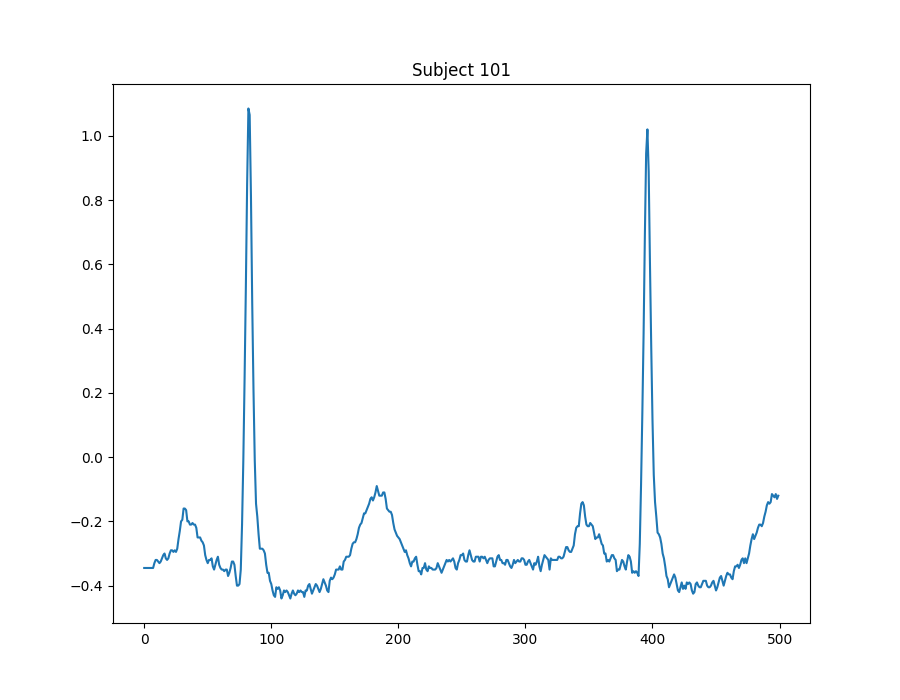

In [22]:
idx = 1
sampfrom = 0
sampto = 650000
record_sig, record_ann, record_ann_sym = extract_from_sbj(idx,sampfrom,sampto)

%matplotlib notebook
fig = plt.figure(figsize=(9,7))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title("Subject {}".format(records_list[idx]))
ax1.plot(record_sig[0][0:500])
plt.show()

### Scipy Filtering

In [14]:
import scipy.io.wavfile
import scipy.signal

#### SNR (Signal to Noise Ratio) 신호대잡음비

$SNR$을 계산하는 식은 다음과 같다  

$$SNR = \frac{P_{signal}}{P_{noise}}$$

이때 $P$는 다음과 같이 구할 수 있다

$$P(x) = \frac{1}{N \cdot\ \sum_{n=0}^{N-1}x(n)^2}$$

여기서 $x(n)$은 $x_s(n)$, Signal과 $x_n(n)$, Noise으로 나뉘어진다

일반적으로 SNR은 dB (데시벨)로 값을 표기하는데, dB 계산은 다음과 같다.

$$P_{db}= 10\cdot\log_{10}(P)$$

따라서 최종 SNR_db는 다음과 같다

$$SNR_{db} = 10\log_{10}\frac{P_{signal}}{P_{noise}} = 10 \log_{10}(P_{signal}) - 10 \log_{10}(P_{noise})$$


#### MIT-BIH Arrhythmia Database SampleRate : 360Hz

In [66]:
sampleRate = 360
nyq = sampleRate/2
data = np.squeeze(np.array(record_sig[0]))
times = np.arange(len(data))/sampleRate

b, a = scipy.signal.butter(3, 0.1) # low pass filter 
filtered = scipy.signal.filtfilt(b, a, data)

<IPython.core.display.Javascript object>


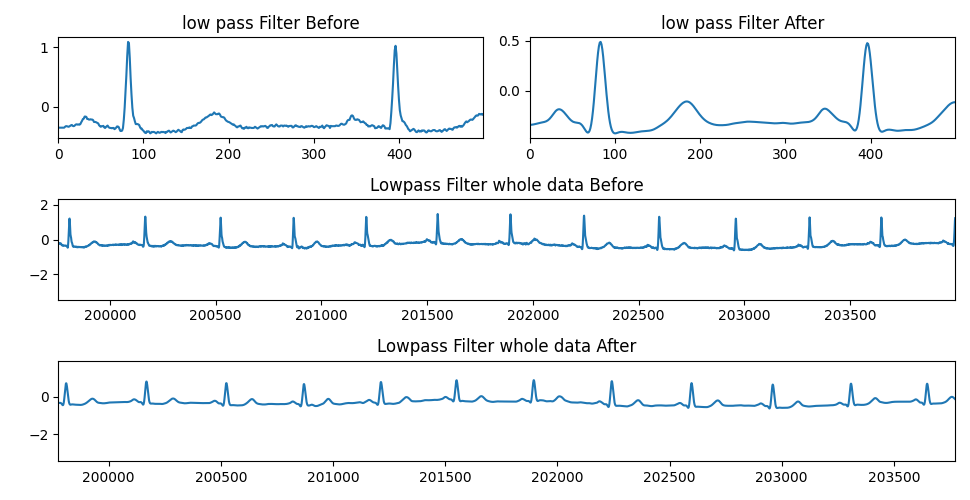

In [67]:
%matplotlib notebook
fig = plt.figure(figsize=(9.7,5))
gs = GridSpec(nrows=3, ncols=2)
ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("low pass Filter Before".format(records_list[idx]))
ax1.plot(record_sig[0][0:500])
ax1.margins(0, .05)

ax2 = fig.add_subplot(gs[0,1])
ax2.set_title("low pass Filter After".format(records_list[idx]))
ax2.plot(filtered[0:500])
ax2.margins(0, .05)

ax3 = fig.add_subplot(gs[1,:])
ax3.set_title("Lowpass Filter whole data Before")
ax3.plot(record_sig[0])
ax3.margins(0, .05)

ax4 = fig.add_subplot(gs[2,:])
ax4.set_title("Lowpass Filter whole data After")
ax4.plot(filtered)
ax4.margins(0, .05)
plt.tight_layout()
plt.show()

Reference : Removal of Noise from Electrocardiogram Using Digital FIR and IIR Filters with Various Methods

**Filter Cutoff Frequency**  

1 step : Highpass Filter Cutoff Frequency : 0.5Hz  

2 step : bandstop Filter Cutoff Frequency : 59.5~60.5Hz  

3 step : Lowpass Filter CutOff Frequency : 100Hz

final : Moving Average Filter

In [ ]:
def hp_filter(cutf):
    return

def bs_filter(cutf):
    return

def lp_filter(cutf):
    return

def mv_filter(cutf):
    
    
    

### MIT-BIH Arrhythmia database Denoising with Wavelet Transform

In [68]:
from skimage.restoration import denoise_wavelet

<IPython.core.display.Javascript object>


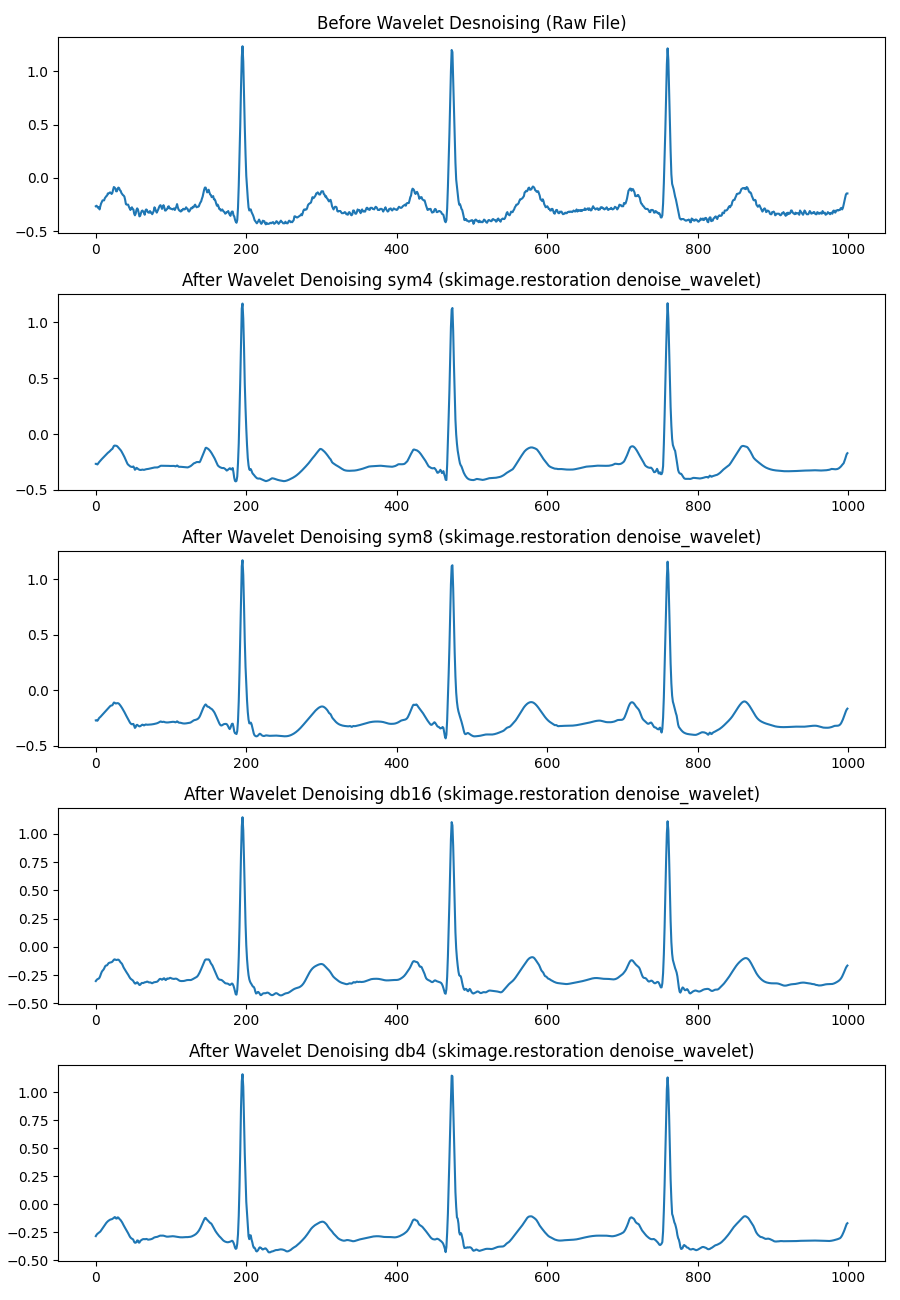

In [100]:
x_denoise_sym4 = denoise_wavelet(data, method="VisuShrink", mode="soft", wavelet_levels=8, wavelet="sym4", rescale_sigma="True")
x_denoise_sym8 = denoise_wavelet(data, method="VisuShrink", mode="soft", wavelet_levels=8, wavelet="sym8", rescale_sigma="True")
x_denoise_db16 = denoise_wavelet(data, method="VisuShrink", mode="soft", wavelet_levels=8, wavelet="db16", rescale_sigma="True")
x_denoise_db4 = denoise_wavelet(data, method="VisuShrink", mode="soft", wavelet_levels=8, wavelet="db4", rescale_sigma="True")


%matplotlib notebook
fig = plt.figure(figsize=(9,11))

ax = fig.add_subplot(5,1,1)
# ax.plot(np.arange(record_len), amp)
ax.plot(np.arange(1000), data[15000:16000])
ax.set_title("Before Wavelet Desnoising (Raw File)")

ax2 = fig.add_subplot(5,1,2)
# ax3.plot(np.arange(len(datarec)), datarec)
ax2.plot(np.arange(1000), x_denoise_sym4[15000:16000])
ax2.set_title("After Wavelet Denoising sym4 (skimage.restoration denoise_wavelet)")

ax3 = fig.add_subplot(5,1,3)
ax3.plot(np.arange(1000), x_denoise_sym8[15000:16000])
ax3.set_title("After Wavelet Denoising sym8 (skimage.restoration denoise_wavelet)")

ax4 = fig.add_subplot(5,1,4)
ax4.plot(np.arange(1000), x_denoise_db16[15000:16000])
ax4.set_title("After Wavelet Denoising db16 (skimage.restoration denoise_wavelet)")

ax5 = fig.add_subplot(5,1,5)
ax5.plot(np.arange(1000), x_denoise_db4[15000:16000])
ax5.set_title("After Wavelet Denoising db4 (skimage.restoration denoise_wavelet)")
plt.tight_layout()
plt.show()